# <div align='center'>第8章 非参数统计(2)</div>

In [14]:
%reset -f
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import statsmodels.stats.anova as sma
import statsmodels.formula.api as smf
import statsmodels.stats.api as smt
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns
import patsy
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

## 8.4 多组数据位置推断

### 8.4.1 Kruskal-Wallis单因素方差分析



#### 例：
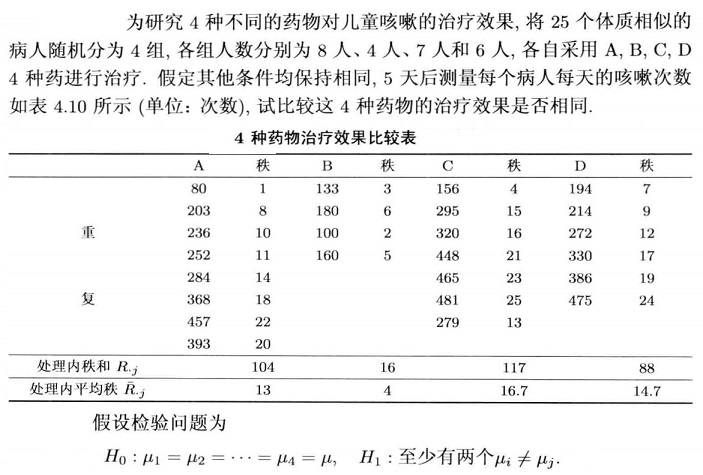

In [15]:
'''
手工编码实现
'''
r1=np.array([1,8,10,11,14,18,22,20])
r2=np.array([3,6,2,5])
r3=np.array([4,15,16,21,23,25,13])
r4=np.array([7,9,12,17,19,24])
n1=len(r1)
n2=len(r2)
n3=len(r3)
n4=len(r4)
n=n1+n2+n3+n4
R1=np.sum(r1)
R2=np.sum(r2)
R3=np.sum(r3)
R4=np.sum(r4)
sst=((R1**2)/n1+(R2**2)/n2+(R3**2)/n3+(R4**2)/n4)-(n*(n+1)**2)/4
mst=n*(n+1)/12
h=sst/mst
chisq_alpha=st.chi2.ppf(0.95,3)
pvalue=st.chi2.sf(h,3)
print('H=%0.8f统计量大于自由度为3，alpha=0.05处的卡方值：%0.8f。'%(h,chisq_alpha))
print('拒绝4种药物疗效相等的原假设。')
print('假设检验的P值为:%0.8f,小于alpha，拒绝原假设。'%pvalue)

H=8.07208791统计量大于自由度为3，alpha=0.05处的卡方值：7.81472790。
拒绝4种药物疗效相等的原假设。
假设检验的P值为:0.04454512,小于alpha，拒绝原假设。


In [16]:
'''
使用Kruskal-Wallis单因素方差分析检验四种药物的疗效是否相同。
结果表明：拒绝疗效相同的原假设。
'''
drug=np.array([80,203,236,252,284,368,457,393,133,180,100,160,156,
               295,320,448,465,481,279,194,214,272,330,386,475])
drugA=np.array([80,203,236,252,284,368,457,393])
drugB=np.array([133,180,100,160])
drugC=np.array([156,295,320,448,465,481,279])
drugD=np.array([194,214,272,330,386,475])
st.kruskal(drugA,drugB,drugC,drugD)

KruskalResult(statistic=8.072087912087923, pvalue=0.04454512424615835)

### 8.4.2 Friedman秩方差分析法


#### 例：
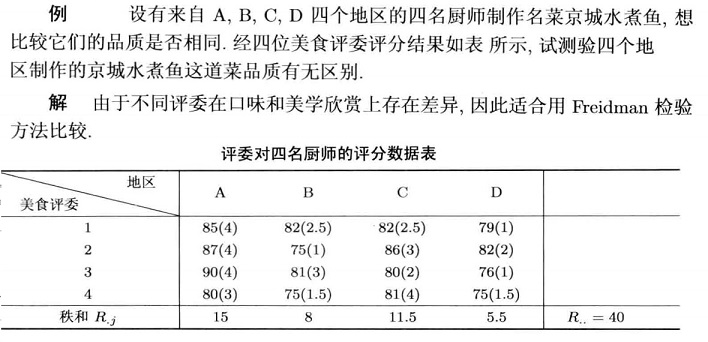
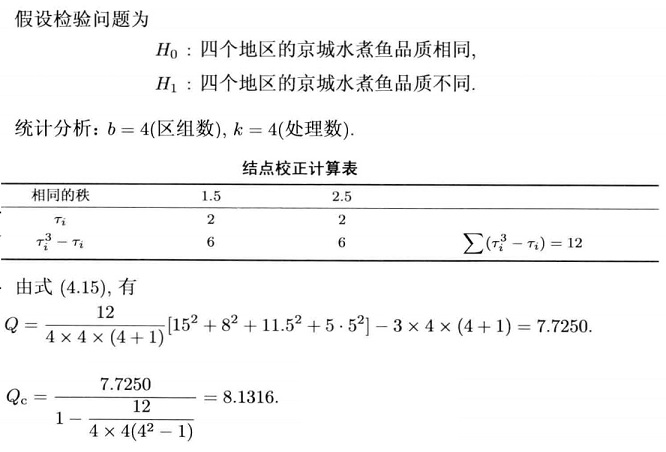
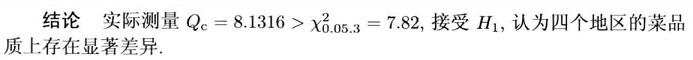

In [17]:
'''
可以按照上述公式计算Q统计量然后进行检验。
Scipy的friedmanchisquare函数有相同功能。
检验结果与上图中的计算结果一致。
'''
a=np.array([85,87,90,80])
b=np.array([82,75,81,75])
c=np.array([82,86,80,81])
d=np.array([79,82,76,75])
st.friedmanchisquare(a,b,c,d),st.chi2.sf(8.131578947368416,3)

(FriedmanchisquareResult(statistic=8.131578947368416, pvalue=0.0433692136979464),
 0.0433692136979464)

### 8.4.3 Hodges-Lehmann检验


- #### 示例：
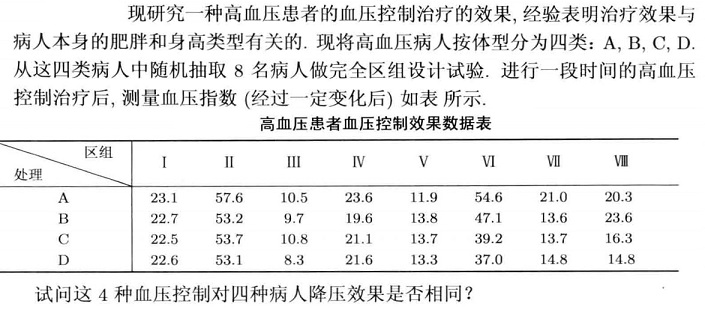

In [18]:
'''
根据上述公式计算HL统计量及其检验的p值。
'''
###HL调整秩计算过程
E=np.array([23.1,57.6,10.5,23.6,11.9,54.6,21.0,20.3])
F=np.array([22.7,53.2,9.7,19.6,13.8,47.1,13.6,23.6])
G=np.array([22.5,53.7,10.8,21.1,13.7,39.2,13.7,16.3])
H=np.array([22.6,53.1,8.3,21.6,13.3,37.0,14.8,14.8])
data=np.vstack([E,F,G,H])
ar_data=data-data.mean(axis=0)
rdata=(st.rankdata(ar_data)).reshape(4,8)

####HL检验计算过程
k=4
b=8
R_i=np.sum(rdata,axis=0)
R_j=np.sum(rdata,axis=1)
###无结点
Q_hat=(k-1)*(np.sum(R_j**2)-(k*b**2*(k*b+1)**2)/4)/ \
      (k*b*(k*b+1)*(2*k*b+1)/6-np.sum(R_i**2)/k)
###有结点
Q_hat1=(k-1)*(np.sum(R_j**2)-(k*(b**2)*(k*b+1)**2)/4)/ \
      (np.sum(rdata**2)-np.sum(R_i**2)/k)
###使用有结点HL统计量Q_hat1进行HL检验
pvalue=st.chi2.sf(Q_hat1,k-1)
print('HL检验统计量：',np.round(Q_hat1,4),'，p值：',np.round(pvalue,5))

###Friedman检验
friedman=st.friedmanchisquare(E,F,G,H)
print('\nFriedman检验统计量：',np.round(friedman.statistic,4),'，p值：',
      np.round(friedman.pvalue,5))

HL检验统计量： 8.5295 ，p值： 0.03625

Friedman检验统计量： 6.45 ，p值： 0.09166


In [19]:
###无结点Q统计量
pvalue1=st.chi2.sf(Q_hat,k-1)
print('HL检验统计量：',np.round(Q_hat,4),'，p值：',np.round(pvalue1,5))

HL检验统计量： 8.5263 ，p值： 0.0363


### 8.4.4 Cochran检验


#### 示例：
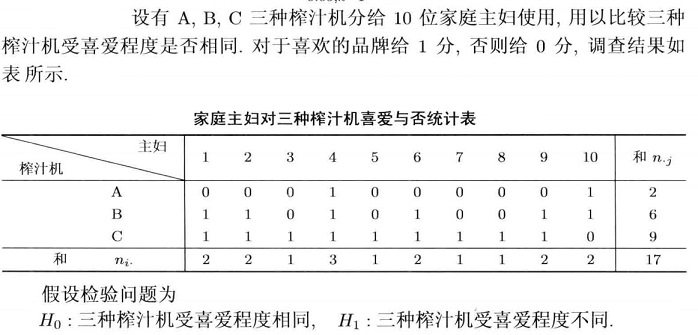

In [20]:
'''
使用StatsModels的cochrans_q函数。
'''
cand1=np.array([0,0,0,1,0,0,0,0,0,1])
cand2=np.array([1,1,0,1,0,1,0,0,1,1])
cand3=np.array([1,1,1,1,1,1,1,1,1,0])
cand=np.vstack([cand1,cand2,cand3])
result=smt.cochrans_q(cand.T)
print('自由度：',result.df,'\n统计量：',np.round(result.statistic,3),
      '\np值：',np.round(result.pvalue,5))

自由度： 2 
统计量： 8.222 
p值： 0.01639


----

## 8.5 分类数据的关联分析
关注变量与变量之间的关系

### 8.5.1 $r\times s$列联表和$\chi^2$独立性检验

- #### 例：
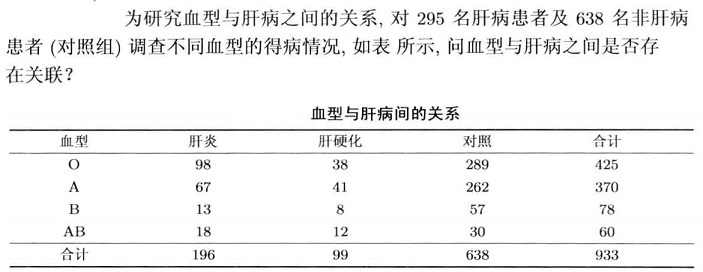

In [21]:
'''
chi2_contingency函数检验两个变量是否有关联关系。
原假设是变量独立。
本例中检验拒绝原假设，说明血型与肝病之间有关联关系。
'''
dataO=np.array([98,38,289])
dataA=np.array([67,41,262])
dataB=np.array([13,8,5])
dataAB=np.array([18,12,30])
data=np.vstack([dataO,dataA,dataB,dataAB])
result=st.chi2_contingency(data,correction=True)
print('统计量、p值以及自由度分别为：',result[0:-1])

统计量、p值以及自由度分别为： (40.89330935472587, 3.039226031646426e-07, 6)


### 8.5.2 Fisher精确性检验
Pearson $\chi^2$ 检验要求二维列表中只允许少于20%的格子期望数小于5，如果多于25%，即$2\times2$格子有一个数小于5不可使用Pearson $\chi^2$检验，此时可以使用$Fisher$精确性检验。
#### 例：
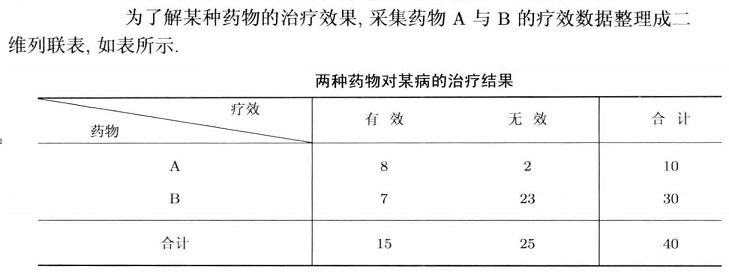

In [22]:
'''
此数据比较适合使用Fisher精确性检验
'''
medicine=np.array([[8,2],[7,23]])
st.fisher_exact(medicine, alternative='greater')

(13.142857142857142, 0.002428599577306265)

### 8.5.3 Mantel-Haenszel检验

- #### 示例：
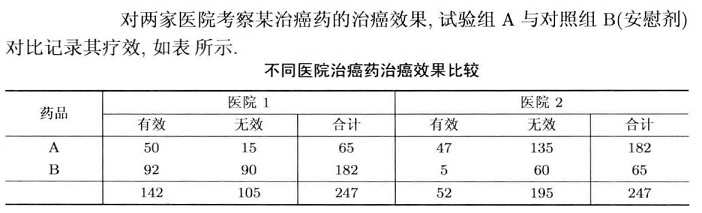

In [23]:
'''
根据公式计算Q值，然后使用自由度为1调用卡方分布的生存函数。
计算结果与R的函数mantelhaen.test有出入。
结论一样：p值远小于0.05，拒绝实验组和对照组治疗效果比值为1的原假设
，两种疗效存在差别。
'''
enh1=65*142/247
var1=65*182*142*105/((247**2)*(247-1))
enh2=182*52/247
var2=182*52*65*195/((247**2)*(247-1))
Q=((50+47-(enh1+enh2))**2)/(var1+var2)
print('Mantel-Haenszel检验统计量：',Q,'，p值：',st.chi2.sf(Q,1))

Mantel-Haenszel检验统计量： 23.011206159110337 ，p值： 1.6105983949463005e-06


### 8.5.4 对数线性模型
- #### 资料来源
使用Statsmodels的广义线性回归（GLM，泊松分布族，log连接函数）实现。具体内容参考：《非参数统计》第2版 第5.7节，王星、褚挺进。清华大学出版社 。<br>
列联表数据的分析以及对数线性模型，可以参看经典教材《属性数据分析引论》第7章，Alan Agresti著，高等教育出版社

- #### 示例：
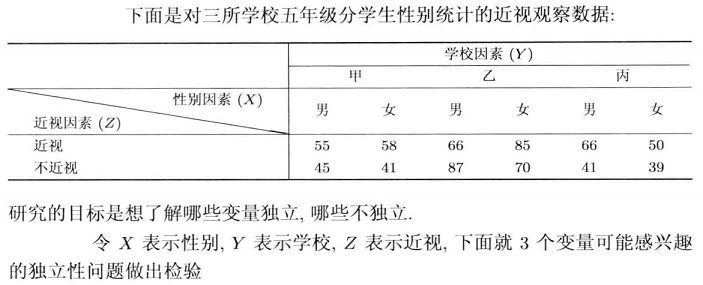


In [24]:
'''
对数线性模型
'''
###单元频数
count1=np.array([55,58,66,85,66,50,45,41,87,70,41,39],dtype='int')
### 近视因素，对近视与非近视进行因子化
f_myopia=np.array(['Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'N', 'N', 'N', 'N', 'N', 'N'])
###性别因素的因子化，M：男性，F：女性
f_gender=np.array(['M','F','M','F','M','F','M','F','M','F','M','F'])
###学校因素：甲、乙、丙
f_school=np.array(['A','A','B','B','C','C','A','A','B','B','C','C'])
#data=np.vstack([f_myopia ,f_gender ,f_school])
dic1={'count1':count1,'myopia':f_myopia,'gender':f_gender,'school':f_school}
###将数据（除单元频数外）放入一个DataFrame
d_dataframe=pd.DataFrame(dic1)


In [25]:

###(X,Y,Z)
formula1='count1 ~ C(gender)+C(school)+C(myopia)'
###(XY,Z)
formula2='count1 ~ C(myopia)+C(gender)*C(school)'
###(X,YZ)
formula3='count1 ~ C(gender)+C(school)*C(myopia)'
###(Y,XZ)
formula4='count1 ~ C(school)+C(myopia)*C(gender)'
###(XY,XZ)
formula5='count1 ~ C(gender)*C(school)+C(gender)*C(myopia)'
###(XY,YZ)
formula6='count1 ~ C(gender)*C(school)+C(school)*C(myopia)'
###(XZ,YZ)
formula7='count1 ~ C(gender)*C(myopia)+C(school)*C(myopia)'

###模型与公式
models=np.array(['(X, Y, Z)','(XY, Z)','(X, YZ)','(Y, XZ)','(XY, XZ)','(XY, YZ)','(XZ, YZ)'])
formulas=np.array([formula1,formula2,formula3,formula4,formula5,formula6,formula7])

In [26]:
df=[]#自由度
LRT=[]#对数似然比
LRT_p=[]#对似然比的p值
PQ=[]#Pearson Q值
PQ_p=[]#Pearson Q值的p值
conclusions=[]#独立与否的结论

###对上述7个模型的公式分别调用glm，广义线性模型（泊松分布族和log连接函数）
#Poisson()类构造器默认使用log连接函数
for formula in formulas:
    result=smf.glm(formula,data=d_dataframe,
                   family=sm.families.Poisson()).fit(use_t=True)
    LRT.append(np.round(result.deviance,6))#对数似然比=回归结果的偏差
    PQ.append(np.round(result.pearson_chi2,6))#Pearson Q等于结果中的Pearson卡方值
    #对数似然比的卡方检验p值
    LRT_p.append(np.round(st.chi2.sf(result.deviance,result.df_resid),8))
    df.append(result.df_resid)#自由度
    #Pearson Q统计量的卡方检验的p值
    q_p=st.chi2.sf(result.pearson_chi2,result.df_resid)
    
    ###根据Pearson Q统计量的卡方检验的p值判定是否独立。
    #设alpha=0.1，相对宽松的置信度。
    #也可以使用对数似然比的卡方检验p值判定是否独立。
    if q_p>=0.1:
        conclusions.append('独立')
    else:
        conclusions.append('不独立')
    PQ_p.append(np.round(q_p,8))

dic_data={'模型':models,'自由度':df,'LRT G2':LRT,'p值1':LRT_p,
          'Pearson Q':PQ,'p值2':PQ_p,'结论':conclusions}
goodness=pd.DataFrame(dic_data)
goodness

,模型,自由度,LRT G2,p值1,Pearson Q,p值2,结论
0,"(X, Y, Z)",7,12.174808,0.094955,12.115692,0.096818,不独立
1,"(XY, Z)",5,10.912539,0.053142,10.903892,0.053319,不独立
2,"(X, YZ)",5,6.360043,0.272744,6.346698,0.273930,独立
3,"(Y, XZ)",6,10.852045,0.093058,10.926133,0.090686,不独立
4,"(XY, XZ)",4,9.589775,0.047935,9.538042,0.048971,不独立
5,"(XY, YZ)",3,5.097773,0.164776,5.088329,0.165442,独立
6,"(XZ, YZ)",4,5.037279,0.283494,5.024954,0.284747,独立


_________________